# Methyl Array Data Filter

## Where the data at?

In [1]:
input_path_450k = '../Data/Raw_Data/Methyl_Array_450k/'
input_path_EPIC = '../Data/Raw_Data/Methyl_Array_EPIC/'

# clinicaldata_path = '../Data/Raw_Data/Clinical_Data/'
output_path = '../Data/Intermediate_Files/'

## Load and Merge Dataframes

In [2]:
import methylcheck
import pandas as pd

input_paths = [
    (input_path_EPIC, 'GSE190931'),      # COG_AAML1031
    (input_path_EPIC, 'GSE124413'),      # COG_AAML0531_03P1
    (input_path_EPIC, 'GSE133986'),      # Japanese AML-05
    (input_path_450k, 'GDC_TARGET-AML'), # AML_TARGET-450k
    (input_path_450k, 'GDC_TCGA-AML'),   # AML_TCGA
    (input_path_EPIC, 'GSE159907'),      # BeatAML
    (input_path_450k, 'GSE152710'),      # MDS_tAML
    (input_path_450k, 'GSE49031'),       # Nordic_ALL
    (input_path_EPIC, 'GDC_TARGET-ALL'), # ALL_TARGET
    (input_path_EPIC, 'GSE147667')       # Tcell_ALL_GRAAL
]

# Load the dataframes from the input paths
df = [methylcheck.load(path + name, silent=True) for path, name in input_paths]

# Concatenate the dataframes in the df list
df = pd.concat(df, keys= [name for _, name in input_paths] , axis=1, join='inner')

print(f' Dataset (df) contains {df.shape[0]} rows (5mC sites) and {df.shape[1]} columns (samples).')

 Dataset (df) contains 452453 rows (5mC sites) and 3845 columns (samples).


## Step 1. Remove Suboptimal Probes

There are several critera for exclusion of probes: Areas that have polymorphisms, cross-hybridization, repeat sequence elements, or base color changes can affect probe quality. Below are publications that have benchmarked probe quality and have provided lists of probes to exclude:

- [Chen et al., 2013](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3592906/)
- [Price et al., 2013](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3740789/)
- [Naeem et al., 2014](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3943510/)
- [DacaRoszak et al., 2015](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4659175/)
- [Zhou et al., 2016](https://academic.oup.com/nar/article/45/4/e22/2290930)

This function removes proves listed as sub-optimal according to [Zhou et al., 2016](https://academic.oup.com/nar/article/45/4/e22/2290930). For the .tsv file containing the annotated probes, download the paper's supplementary material. See figure 5 of their paper for detailed description.

In [3]:
def exclude_suboptimal_probes(df):
    '''This function removes proves listed as sub-optimal according to:
    
    Zhou, W., Laird, P. W. & Shen, H.. Comprehensive characterization,
    annotation and innovative use of Infinium DNA methylation BeadChip probes.
    Nucleic Acids Research gkw967 (2016).
    doi:10.1093/nar/gkw967

    For the .tsv file containing the annotated probes, download the paper's
    supplementary material.
    '''
    zhou2016_probes = pd.read_csv('../Data/UnreliableProbesList_Zhou2016/EPIC.anno.GRCh38.tsv', sep='\t',index_col=0)

    unreliable_probes = list(zhou2016_probes[zhou2016_probes['MASK.general'] == True].index)

    df_ = df[~df.index.isin(unreliable_probes)]
    
    print(f'Removed {df.shape[0]-df_.shape[0]} suboptimal probes. {df_.shape[0]} probes remaining.')
    return(df_)

df = exclude_suboptimal_probes(df)

Removed 47382 suboptimal probes. 405071 probes remaining.


## Step 2. Remove sex-linked probes

In [4]:
df = methylcheck.exclude_sex_control_probes(df, '450k', no_sex=True, no_control=False, verbose=True)

450k: Removed 9570 sex-linked probes from 3845 samples. 395501 probes remaining.


### Evaluate Missing Values

In [5]:
df

GSE190931                                           
               202897270043_R01C01 202897270043_R02C01 202897270043_R03C01   
IlmnID                                                                       
cg00000029                     NaN                 NaN               0.720  \
cg00000109                   0.932                 NaN               0.962   
cg00000165                   0.101                 NaN               0.588   
cg00000236                   0.838                 NaN               0.822   
cg00000289                     NaN                 NaN               0.885   
...                            ...                 ...                 ...   
ch.9.97139671F                 NaN                 NaN                 NaN   
ch.9.98463211R               0.043                 NaN               0.030   
ch.9.98957343R                 NaN                 NaN                 NaN   
ch.9.98959675F                 NaN                 NaN               0.105   
ch.9.991104F                   NaN                 NaN               0.085   

                                                                             
               202897270043_R04C01 202897270043_R05C01 202897270043_R06C01   
IlmnID                                                                       
cg00000029                   0.867                 NaN               0.575  \
cg00000109                   0.881               0.876               0.924   
cg00000165                   0.157               0.625                 NaN   
cg00000236                   0.904                 NaN               0.674   
cg00000289                     NaN                 NaN                 NaN   
...                            ...                 ...                 ...   
ch.9.97139671F                 NaN                 NaN                 NaN   
ch.9.98463211R               0.044               0.122               0.054   
ch.9.98957343R                 NaN                 NaN                 NaN   
ch.9.98959675F                 NaN                 NaN                 NaN   
ch.9.991104F                   NaN                 NaN                 NaN   

                                                                             
               202897270043_R07C01 202897270043_R08C01 202897270045_R01C01   
IlmnID                                                                       
cg00000029                     NaN               0.854                 NaN  \
cg00000109                   0.951               0.885               0.953   
cg00000165                   0.674                 NaN                 NaN   
cg00000236                     NaN                 NaN               0.920   
cg00000289                     NaN                 NaN                 NaN   
...                            ...                 ...                 ...   
ch.9.97139671F                 NaN                 NaN                 NaN   
ch.9.98463211R               0.041               0.065                 NaN   
ch.9.98957343R                 NaN                 NaN                 NaN   
ch.9.98959675F                 NaN                 NaN                 NaN   
ch.9.991104F                   NaN                 NaN                 NaN   

                                    ...           GSE147667   
               202897270045_R02C01  ... 201233760140_R05C01   
IlmnID                              ...                       
cg00000029                     NaN  ...               0.901  \
cg00000109                     NaN  ...               0.923   
cg00000165                     NaN  ...               0.125   
cg00000236                     NaN  ...               0.939   
cg00000289                     NaN  ...               0.905   
...                            ...  ...                 ...   
ch.9.97139671F                 NaN  ...                 NaN   
ch.9.98463211R               0.074  ...               0.039   
ch.9.98957343R                 NaN  ...              

<Axes: >

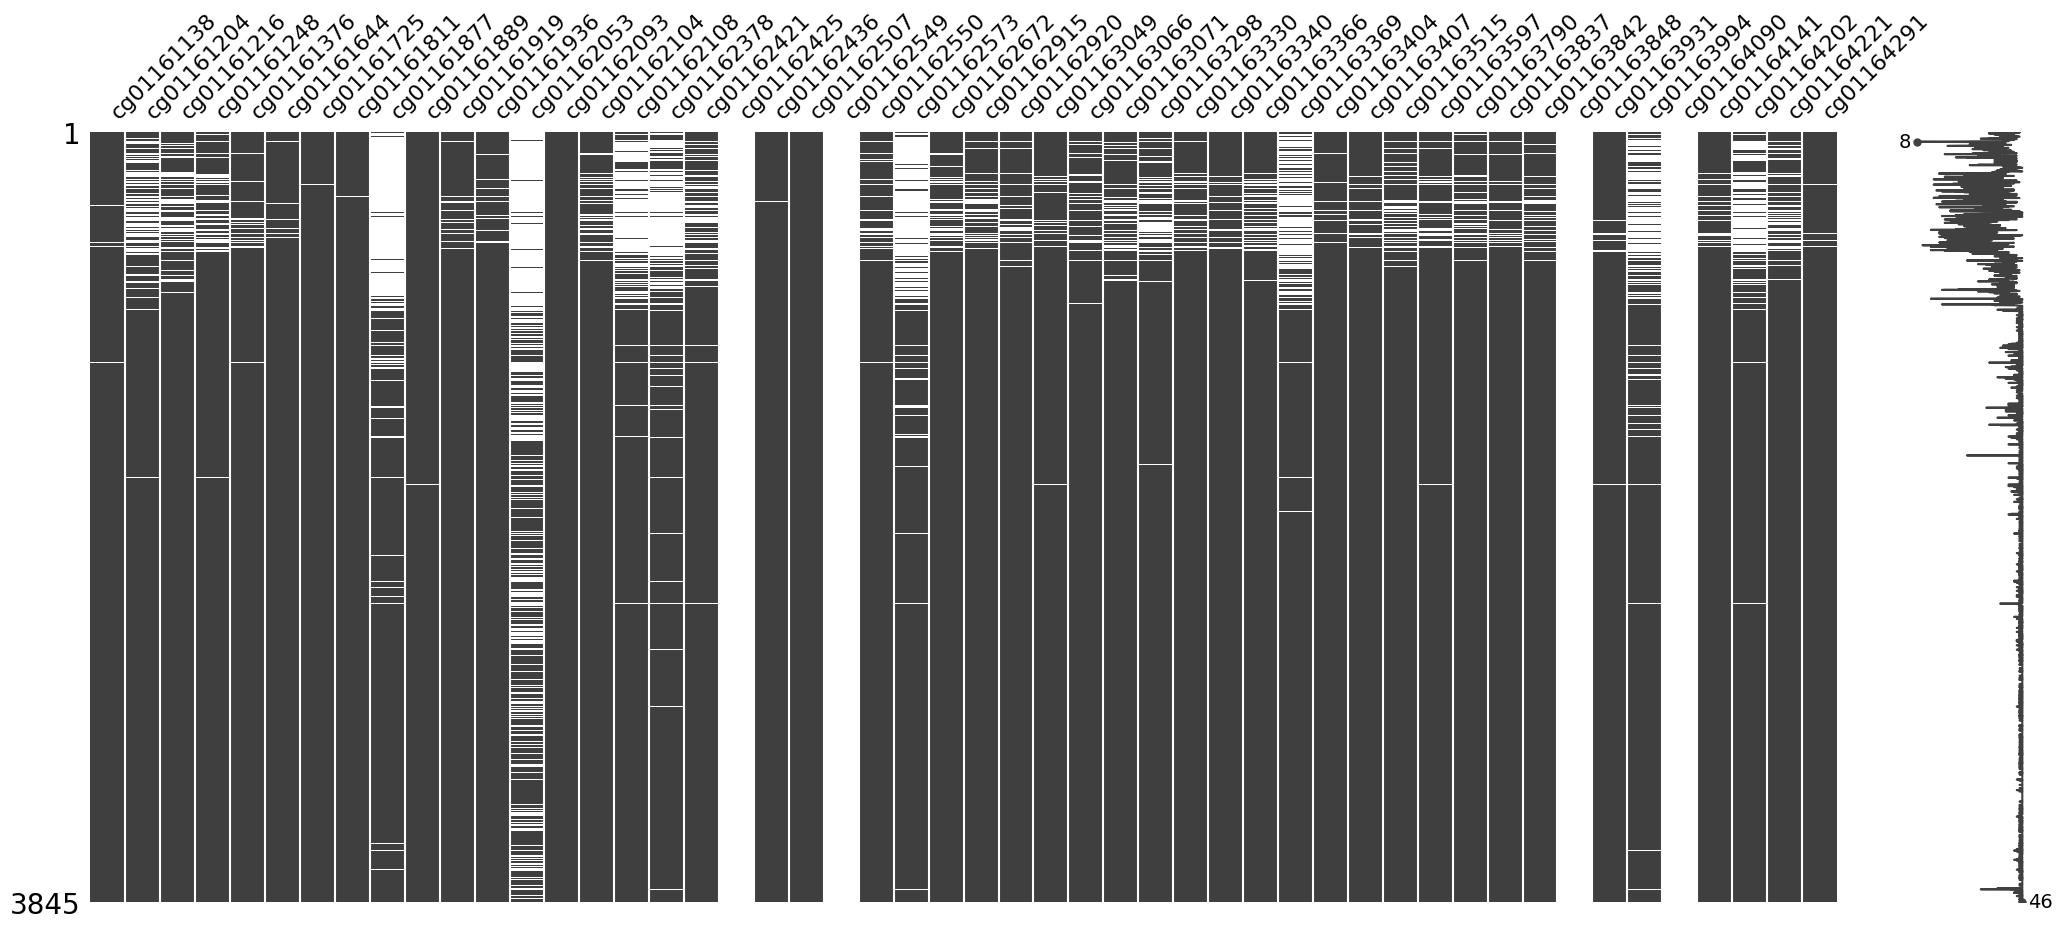

In [6]:
import missingno as msno

# Plot the missing values
msno.matrix(df.iloc[20000:20050,:].T.reset_index(drop=True))

## Step 3. Remove cell line samples

In [7]:
GSE49031_colon_cancer_cell_line_samples =  [('GSE49031', '5723662002_R06C02'),
                                            ('GSE49031', '5723662025_R06C02'),
                                            ('GSE49031', '5854945004_R04C01'),
                                            ('GSE49031', '5854945004_R06C02'),
                                            ('GSE49031', '5859501021_R04C01'),
                                            ('GSE49031', '5859501021_R06C02'),
                                            ('GSE49031', '5975819012_R05C02'),
                                            ('GSE49031', '5975819012_R06C02'),
                                            ('GSE49031', '6005574026_R05C02'),
                                            ('GSE49031', '6005574026_R06C02'),
                                            ('GSE49031', '6929726092_R06C02')]

df = df.drop(GSE49031_colon_cancer_cell_line_samples, axis=1)

## Step 4. Exclude samples in which >20% of probes have failed p-values

A strict metric implemented by Illumina quality control process is `FAIL by pval`, which happens if, for a given sample, the detection p-value is >0.05 in >20% of probes.

Recall that detection p-values measure how likely it is that signals are background fluorescence. There are a few methods for calculating these:  ```SeSAMe``` and ```methylprep``` implement pOOBAH, which stands for P-value Out Of Band (OOB) probes for Array Hybridization. For more, see SeSAMe's paper in [Zhou et al. , 2018](https://pubmed.ncbi.nlm.nih.gov/30085201/).

In other words, we will exclude samples that Illumina QC categorizes as FAIL(pval) for meeting the condition: (pOOBAH > 0.05) >20% probes. Here, failed probes are listed as `NaN`, so we will count the number of `NaN` values in each sample and exclude samples that have more than 20% `NaN` values.

In [8]:
def exclude_failed_samples(df2):
    '''This function removes samples that have more than 20% NaN values.'''

    # Calculate the number of NaN values in each sample
    nan_count = df2.isna().sum()

    # Calculate the total number of probes (rows) in the DataFrame
    total_probes = df2.shape[0]

    # Calculate the percentage of NaN values for each sample
    nan_percentage = (nan_count / total_probes) * 100

    # Identify samples that meet the condition of having more than 20% NaN values
    samples_to_exclude = nan_percentage[nan_percentage > 20].index

    # Exclude samples that meet the condition from the DataFrame
    filtered_df2 = df2.drop(samples_to_exclude, axis=1)
    
    # Print the number of samples before and after filtering
    print(
    f"Removed {df2.shape[1]-filtered_df2.shape[1]} samples ({round((df2.shape[1]-filtered_df2.shape[1])/df2.shape[1]*100,2)}%). {filtered_df2.shape[1]} samples remaining."
    )
    
    return filtered_df2

df = exclude_failed_samples(df)


Removed 466 samples (12.15%). 3368 samples remaining.


## Step 5. Exclude CpG probes that are missing in >5% of samples

In [9]:
def probe_cutoff(qc_betas, threshold):
    qc_betas2 = qc_betas.dropna(axis=0, thresh = int(threshold*qc_betas.shape[1]))
    print(f'{qc_betas.shape[0] - qc_betas2.shape[0]} probes removed. {qc_betas2.shape[0]} probes remaining.')

    return(qc_betas2)

df = probe_cutoff(df, threshold=0.95)

62253 probes removed. 333248 probes remaining.


### Evaluate Missing Values

<Axes: >

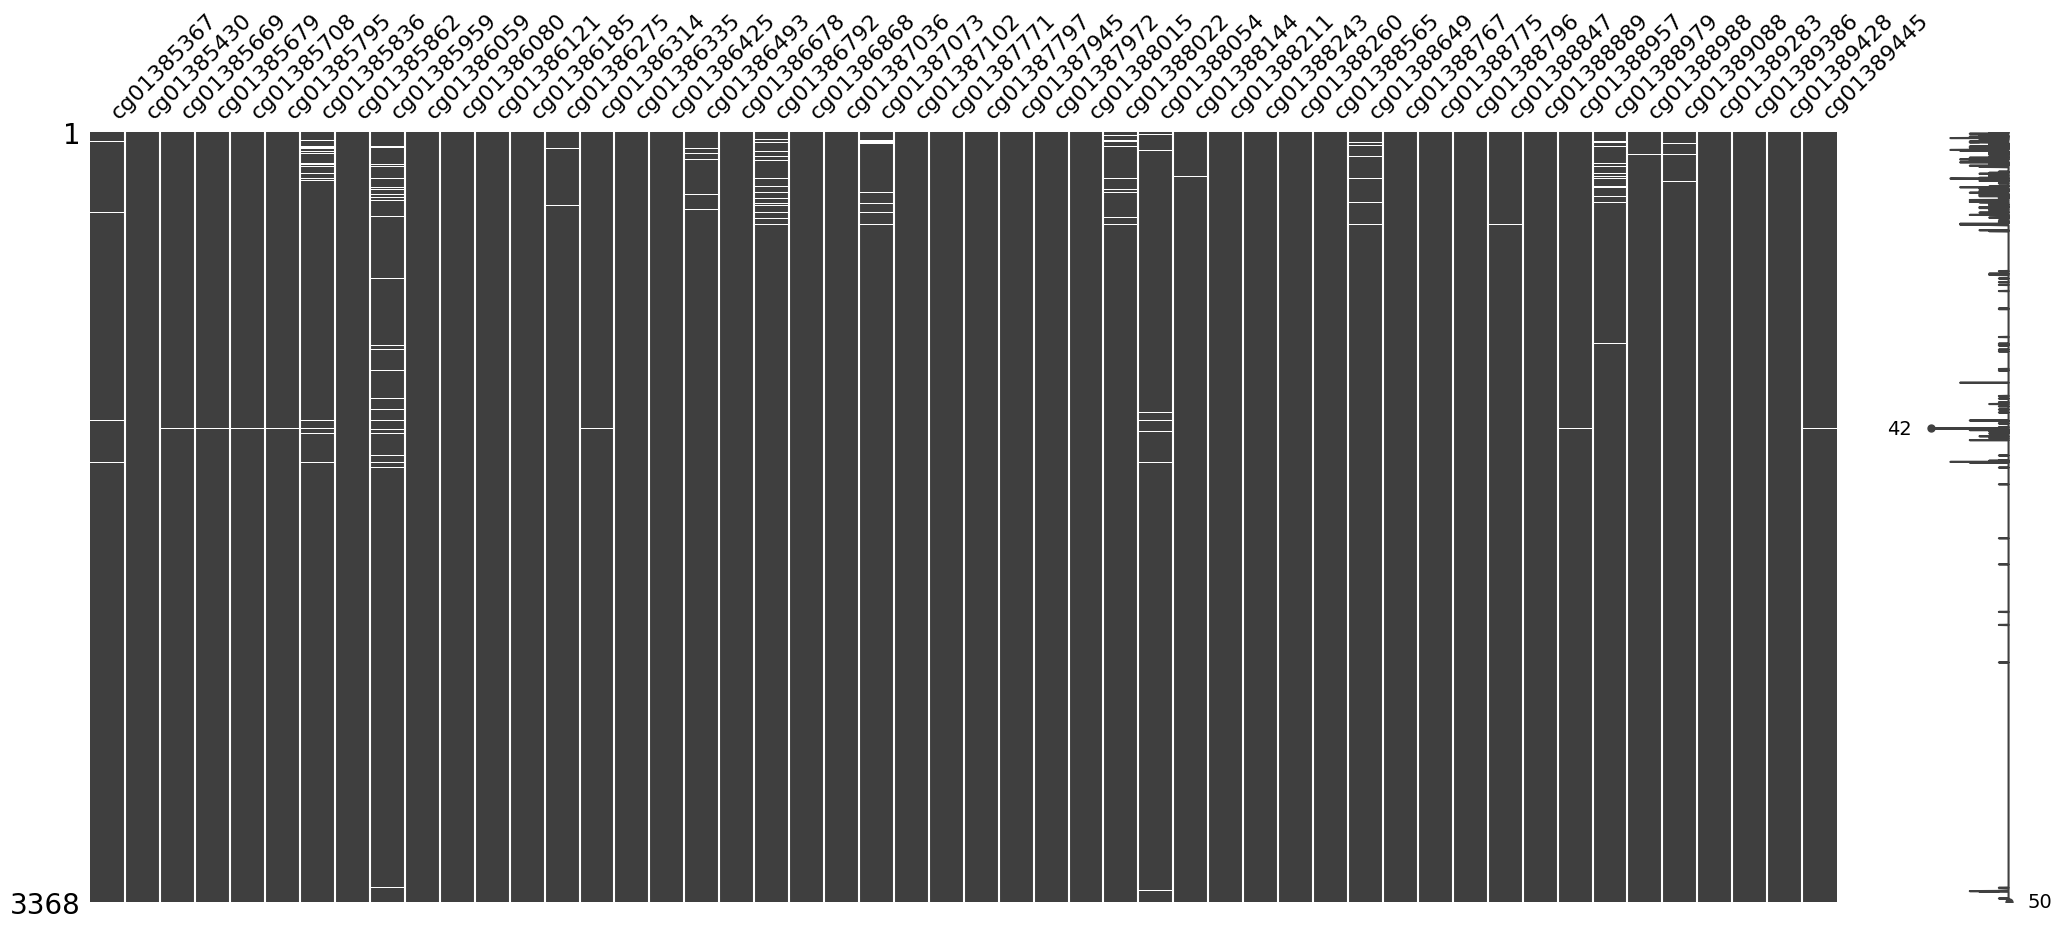

In [10]:
# Plot the missing values
msno.matrix(df.iloc[20000:20050,:].T.reset_index(drop=True))

## Step 6. Impute remaining missing values

- __Method__: Mean (it replaces each missing value by averaging all the known values for that CpG across samples).

- __It turns out simple mean works well in methylation β-values__:

    _In conclusion, the consolidated and manufacturer encouraged practice to use β-value seems appropriate for DNA methylation data imputation. The choice of the best imputation method is somewhat more subtle and depends essentially on the available computational resources and the amount of missing values. Independently of the expected missingness mechanisms, regression-based methods provide on average more accurate estimates of the missing values. However, imputations with regression methods in the presence of limited computational resources can be a rather challenging task. In such cases, the simple mean approach can surprisingly be a better choice than more sophisticated methods_ ([Lena et al., 2020](https://pubmed.ncbi.nlm.nih.gov/32600298/)).

- __This step inevitably introduces bias__: More sophisticated methods, however, also do. Benchmarks done by the paper above and others reported that the increase in error across methods is roughly similar ([see here](https://scikit-learn.org/stable/auto_examples/impute/plot_missing_values.html#sphx-glr-auto-examples-impute-plot-missing-values-py)), which places `imputation by mean` as an equivalently error-prone method compared to others but vastly simpler and faster.

In [11]:
# Impute missing values based on mean of the row (probes)

df = df.fillna(df.mean(axis=0)).round(3)

## Step 6. Perform batch correction

- __pyCombat__: a Python tool for batch effects correction in high-throughput molecular data using empirical Bayes methods

- __Github__: [https://epigenelabs.github.io/pyComBat/](https://epigenelabs.github.io/pyComBat/)

- __Implementation Preprint__: [bioRxiv](https://doi.org/10.1101/2020.03.17.995431)

- __Original Paper__: [Adjusting batch effects in microarray expression data using empirical Bayes methods](https://pubmed.ncbi.nlm.nih.gov/16632515/)

In [12]:
from combat.pycombat import pycombat

# Correct batch effects in the training dataset
df = pycombat(data = df, batch = df.columns.droplevel(1)).round(3)

print('Succesfully corrected batch effects in the training dataset.')


Found 10 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Succesfully corrected batch effects in the training dataset.


## Step 7. Remove outliers by PCA

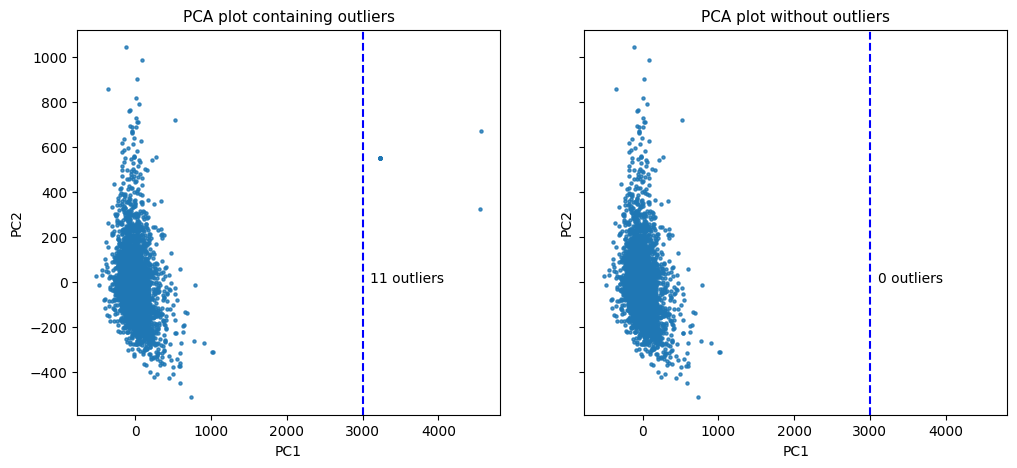

Removed 11 outliers. 3357 samples remaining.


In [13]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def remove_outliers(df, threshold=3000):
    '''This function removes outliers from a DataFrame using PCA.
    '''
    # Standardize the data
    X_std = StandardScaler().fit_transform(df.T)

    # Perform PCA
    pca = PCA(n_components=2, random_state=42)
    principal_components = pca.fit_transform(X_std)

    # Create a DataFrame with the PCA data
    principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'], index=df.columns)

    # Select non-outlier samples
    non_outliers = principal_df[principal_df['PC1'] < threshold]
    outliers = principal_df[principal_df['PC1'] >= threshold].index

    # Remove outliers from the input DataFrame
    df_filtered = df.drop(outliers, axis=1)

    # Plot PCA data
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4), sharex=True, sharey=True)
    ax1.scatter(principal_df['PC1'], principal_df['PC2'], s=5, alpha=0.8)
    ax1.set_title('PCA plot containing outliers', fontsize=11)
    ax2.scatter(non_outliers['PC1'], non_outliers['PC2'], s=5, alpha=0.8)
    ax2.set_title('PCA plot without outliers', fontsize=11)

    # Add a vertical line to indicate the threshold and count number of samples to the right and left of the line
    ax1.axvline(x=threshold, color='b', linestyle='--')
    ax2.axvline(x=threshold, color='b', linestyle='--')
    ax1.text(threshold+100, 0, f'{principal_df[principal_df["PC1"] >= threshold].shape[0]} outliers', fontsize=10)
    ax2.text(threshold+100, 0, '0 outliers', fontsize=10)


    for ax in (ax1, ax2):
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')

    plt.show()

    print(f'Removed {df.shape[1]-df_filtered.shape[1]} outliers. {df_filtered.shape[1]} samples remaining.')
    return df_filtered

# Example usage:
df = remove_outliers(df)


## Save Dataset

In [14]:
df = df.T.reset_index(level=0, names='Batch')

print(
    f' Dataset (df) contains {df.shape[1]} rows (mC sites) and {df.shape[0]} columns (samples).')
df.to_pickle(output_path + '2_MethylData_Processing_Output.pkl')

print(
    f'Successfuly saved processed methyl dataset.\nPath: {output_path}')


 Dataset (df) contains 333249 rows (mC sites) and 3357 columns (samples).
Successfuly saved processed methyl dataset.
Path: ../Data/Intermediate_Files/


## Watermark

In [15]:
%load_ext watermark

In [16]:
%watermark -v -p methylcheck,pandas

Python implementation: CPython
Python version       : 3.8.16
IPython version      : 8.12.2

methylcheck: 0.8.5
pandas     : 2.0.1

